In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

### Question: does `model` returns `[0 prob, 1 prob]` before softmax?

In [2]:
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    AutoConfig,
    TextClassificationPipeline,
)
from engine.data import prepare_data_for_fine_tuning, read_data
from engine.xai import FeatureAblationText
import pandas as pd
from engine.ner_detector import text_preprocess

2024-12-10 18:18:26.156449: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-10 18:18:26.165666: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733851106.177565  259986 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733851106.181033  259986 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-10 18:18:26.193342: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [3]:
MODEL_ID = "roberta-base"
MODEL_PATH = "output/checkpoint-2025/model.safetensors"
tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)

In [4]:
test = pd.read_csv("data/coaid/test.csv")
test['text'] = text_preprocess(test['text'].to_list())
print(test)
test_dataset = prepare_data_for_fine_tuning(test, tokenizer)

                                                   text  label
0                  Eddie Van Halen Dies of Cancer at 65      0
1     Have the Public Health Restrictions Gone Too F...      0
2     My experience battling COVID-19 - Medical News...      0
3     U.S. Government to Increase PPE Shipments to N...      0
4     Frequently Asked Questions about Hand Hygiene ...      0
...                                                 ...    ...
1087  How to Enjoy the Fourth of July Weekend Amid t...      0
1088         Wearing a Mask Doesn't Cause CO2 Poisoning      0
1089  Brain Affected in 1 in 3 Cases of Severe COVID-19      0
1090      CDC Reverses Guidance on Asymptomatic Testing      0
1091  Guidance for Child Care Programs that Remain Open      0

[1092 rows x 2 columns]


Map:   0%|          | 0/1092 [00:00<?, ? examples/s]

In [5]:
import torch
def get_device():
    if torch.cuda.is_available():
        print("CUDA is available. Using GPU.")
        return "cuda"
    else:
        print("CUDA not available. Using CPU.")
        return "cpu"

In [6]:
config = AutoConfig.from_pretrained(MODEL_ID)
device = get_device()
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_PATH, config=config
)
model.eval()
pipeline = TextClassificationPipeline(
    model=model, tokenizer=tokenizer, top_k=2, device=device
)

CUDA not available. Using CPU.


In [7]:
%%capture
if(device == "cuda"):
    model.cuda()
else:
    model.cpu()

In [8]:
obs = test["text"].tolist()[247]
if(device == "cuda"):
    obs_pt = pipeline.tokenizer(obs, return_tensors="pt")['input_ids'].cuda()
else:
    obs_pt = pipeline.tokenizer(obs, return_tensors="pt")['input_ids'].cpu()

print(obs)
print(obs_pt)


Framework for Implementation of COVID-19 Community Mitigation Measures for Lower-Resource Countries
tensor([[    0, 47948, 31466,    13, 39046,     9,  6247, 43814,    12,  1646,
          2573, 12663, 18541, 34131,    13,  9978,    12, 47279, 17658,     2]])


In [9]:
test["text"].tolist()[247]

'Framework for Implementation of COVID-19 Community Mitigation Measures for Lower-Resource Countries'

In [10]:
def forward(obs):
    return model(obs).logits

In [11]:

attr = FeatureAblationText(forward)
print(attr)
exp = attr.get_attributions([obs_pt])
exp

tensor([[[ 0.0000e+00, -1.6838e-06,  1.2368e-06,  2.5332e-07,  4.1276e-06,
           2.0564e-06, -1.2666e-06,  7.4506e-07, -5.9605e-07, -3.4273e-07,
          -1.9222e-06, -1.4901e-06,  1.3411e-06,  3.1441e-06,  9.6858e-07,
          -1.8775e-06,  1.3411e-07,  3.6210e-06, -2.1756e-06,  2.6822e-07],
         [ 0.0000e+00, -7.3016e-07, -9.4995e-08, -5.2340e-07,  1.1586e-06,
           3.5949e-07, -1.5758e-06, -2.3283e-07, -7.5065e-07, -8.3074e-07,
          -1.4137e-06, -1.2442e-06, -9.4995e-08,  3.7253e-07, -6.8918e-07,
          -1.2070e-06, -1.1139e-06, -5.0105e-07, -1.5516e-06, -1.0170e-06]]])

In [12]:
tokens = pipeline.tokenizer.convert_ids_to_tokens(obs_pt[0])
print(tokens)

['<s>', 'Fram', 'ework', 'Ġfor', 'ĠImplementation', 'Ġof', 'ĠCO', 'VID', '-', '19', 'ĠCommunity', 'ĠMit', 'igation', 'ĠMeasures', 'Ġfor', 'ĠLower', '-', 'Resource', 'ĠCountries', '</s>']


In [13]:
import spacy

NER = spacy.load("en_core_web_sm")

doc = NER(obs)

print("Entities in the text:")
for ent in doc.ents:
    print(f"{ent.text} ({ent.label_}) - {spacy.explain(ent.label_)}")

Entities in the text:
Framework for Implementation of COVID-19 Community Mitigation Measures for Lower-Resource Countries (ORG) - Companies, agencies, institutions, etc.


In [14]:
print("\nTokens and Their NER Information: \n")

for token in doc:
    if token.ent_type_:
        print(f"Token: {token.text}, Entity Type: {token.ent_type_} ({spacy.explain(token.ent_type_)})")
    else:
        print(f"Token: {token.text}, Not part of any entity.")


Tokens and Their NER Information: 

Token: Framework, Entity Type: ORG (Companies, agencies, institutions, etc.)
Token: for, Entity Type: ORG (Companies, agencies, institutions, etc.)
Token: Implementation, Entity Type: ORG (Companies, agencies, institutions, etc.)
Token: of, Entity Type: ORG (Companies, agencies, institutions, etc.)
Token: COVID-19, Entity Type: ORG (Companies, agencies, institutions, etc.)
Token: Community, Entity Type: ORG (Companies, agencies, institutions, etc.)
Token: Mitigation, Entity Type: ORG (Companies, agencies, institutions, etc.)
Token: Measures, Entity Type: ORG (Companies, agencies, institutions, etc.)
Token: for, Entity Type: ORG (Companies, agencies, institutions, etc.)
Token: Lower, Entity Type: ORG (Companies, agencies, institutions, etc.)
Token: -, Entity Type: ORG (Companies, agencies, institutions, etc.)
Token: Resource, Entity Type: ORG (Companies, agencies, institutions, etc.)
Token: Countries, Entity Type: ORG (Companies, agencies, institutio

In [15]:
print(len(tokens))

tokens_clear = [s.replace("Ġ", "") for s in tokens]
tokens_clear = tokens_clear[1:len(tokens_clear)-1]
print(tokens_clear)

print(exp)
print(len(exp))

20
['Fram', 'ework', 'for', 'Implementation', 'of', 'CO', 'VID', '-', '19', 'Community', 'Mit', 'igation', 'Measures', 'for', 'Lower', '-', 'Resource', 'Countries']
tensor([[[ 0.0000e+00, -1.6838e-06,  1.2368e-06,  2.5332e-07,  4.1276e-06,
           2.0564e-06, -1.2666e-06,  7.4506e-07, -5.9605e-07, -3.4273e-07,
          -1.9222e-06, -1.4901e-06,  1.3411e-06,  3.1441e-06,  9.6858e-07,
          -1.8775e-06,  1.3411e-07,  3.6210e-06, -2.1756e-06,  2.6822e-07],
         [ 0.0000e+00, -7.3016e-07, -9.4995e-08, -5.2340e-07,  1.1586e-06,
           3.5949e-07, -1.5758e-06, -2.3283e-07, -7.5065e-07, -8.3074e-07,
          -1.4137e-06, -1.2442e-06, -9.4995e-08,  3.7253e-07, -6.8918e-07,
          -1.2070e-06, -1.1139e-06, -5.0105e-07, -1.5516e-06, -1.0170e-06]]])
1


In [16]:
from engine.tokens_aggregate import TokenAggregate

In [17]:
aggregate_list = TokenAggregate.generate_aggregate_list(doc,exp[0],tokens_clear,tokens)

In [18]:
from engine.xai import FeatureAblation
from engine.tokens_aggregate import TokenAggregate
from engine.ner_detector import tokenize_evaluate_and_detect_NERs,generate_aggregates

all_aggregate = generate_aggregates(pipeline,[test["text"].tolist()[16]])

1it [00:00,  3.17it/s]


In [19]:
print(all_aggregate)

[[<engine.tokens_aggregate.TokenAggregate object at 0x731bbf470280>, <engine.tokens_aggregate.TokenAggregate object at 0x731bb41c46a0>, <engine.tokens_aggregate.TokenAggregate object at 0x731bb41c4430>, <engine.tokens_aggregate.TokenAggregate object at 0x731bb41c4670>, <engine.tokens_aggregate.TokenAggregate object at 0x731bb41c45b0>, <engine.tokens_aggregate.TokenAggregate object at 0x731bb41c43d0>, <engine.tokens_aggregate.TokenAggregate object at 0x731bb41c4040>, <engine.tokens_aggregate.TokenAggregate object at 0x731bb41c4280>, <engine.tokens_aggregate.TokenAggregate object at 0x731bb41c41f0>, <engine.tokens_aggregate.TokenAggregate object at 0x731bb41c4460>]]


In [20]:
for doc_aggreagtes in all_aggregate:
    for aggregate in doc_aggreagtes:
        # if(len(aggregate.spacy_token)>1):
        print(aggregate)

Is spacy NER: ['']
spacy token: ['Why']
Our model clean: ['Why']
Our model dirty: ['Why']
model exp: [-8.642673492431641e-07]

Is spacy NER: ['']
spacy token: ['are']
Our model clean: ['are']
Our model dirty: ['Ġare']
model exp: [-3.7550926208496094e-06]

Is spacy NER: ['']
spacy token: ['infections']
Our model clean: ['infections']
Our model dirty: ['Ġinfections']
model exp: [-1.043081283569336e-07]

Is spacy NER: ['']
spacy token: ['from']
Our model clean: ['from']
Our model dirty: ['Ġfrom']
model exp: [-1.087784767150879e-06]

Is spacy NER: ['']
spacy token: ['animals']
Our model clean: ['animals']
Our model dirty: ['Ġanimals']
model exp: [-1.430511474609375e-06]

Is spacy NER: ['']
spacy token: ['so']
Our model clean: ['so']
Our model dirty: ['Ġso']
model exp: [1.043081283569336e-06]

Is spacy NER: ['']
spacy token: ['dangerous']
Our model clean: ['dangerous']
Our model dirty: ['Ġdangerous']
model exp: [-1.5497207641601562e-06]

Is spacy NER: ['']
spacy token: ['to']
Our model clea

In [21]:
test = pd.read_csv("data/liar/test.csv")

In [22]:
token_exp_NERs = tokenize_evaluate_and_detect_NERs(pipeline,test["text"].tolist()[253:254],ners_to_calculate_ablation=['PERSON'])

1it [00:00, 6743.25it/s]
100%|██████████| 1/1 [00:00<00:00, 27962.03it/s]
1it [00:00, 10.37it/s]
100%|██████████| 1/1 [00:00<00:00, 12018.06it/s]


In [31]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

data_names = ["liar"]
results_for_data_filtered = {}
for data_name in data_names:
    file = f"data/{data_name}/test.csv"
    test = pd.read_csv(file)
    token_exp_NERs = tokenize_evaluate_and_detect_NERs(pipeline,test["text"].tolist())
    results_for_data_filtered[data_name] = token_exp_NERs
    all_ner_types = set()

    for _,_,ner in token_exp_NERs:
            all_ner_types.add(ner)
            
    exps = {}
    for ner_type in all_ner_types:
        exps[ner_type] = []



    for token,exp,ner in token_exp_NERs:
        exps[ner].append(exp)


    plt.figure(figsize=(20,6))
    sns.boxplot(exps)
    plt.title(f"test for {file}")
    plt.show()

250it [03:10,  1.31it/s]


Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/dawid/miniconda3/envs/dl/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_259986/1496031516.py", line 10, in <module>
    token_exp_NERs = tokenize_evaluate_and_detect_NERs(pipeline,test["text"].tolist())
  File "/home/dawid/studies/master-2/master24nlp/nlp-2024-fake/engine/ner_detector.py", line 73, in tokenize_evaluate_and_detect_NERs
    if ners_to_calculate_ablation:
  File "/home/dawid/studies/master-2/master24nlp/nlp-2024-fake/engine/ner_detector.py", line 169, in generate_aggregates
    NER = spacy.load(spacy_model)
  File "/home/dawid/studies/master-2/master24nlp/nlp-2024-fake/engine/xai.py", line 29, in get_attributions
    exp = self.attr.attribute(ob)
  File "/home/dawid/miniconda3/envs/dl/lib/python3.10/site-packages/captum/log/__init__.py", line 42, in wrapper
    return func(*args, **kwargs)
  File "/home/dawid

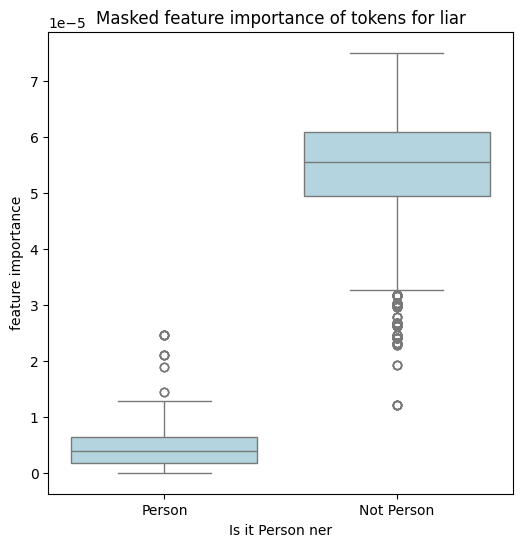

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

for data_name in data_names:
    token_exp_NERs = results_for_data_filtered[data_name]
    all_ner_types = set()

    for _, _, ner in token_exp_NERs:
        all_ner_types.add(ner)

    exps = {"Person":[],"Not Person":[]}


    for token, exp, ner in token_exp_NERs:
        if(ner == "PERSON"):
            exps["Person"].append(abs(exp))
        else:
            exps["Not Person"].append(abs(exp))

    plt.figure(figsize=(6, 6))
    
    # Assign the same color to all boxes
    box_colors = ["lightblue"] * len(exps)  # A list of the same color for all boxes
    plt.ylabel("feature importance")
    plt.xlabel("Is it Person ner")
    sns.boxplot(data=exps, palette=box_colors)  # Pass the color list
    plt.title(f"Masked feature importance of tokens for {data_name}")
    plt.savefig(f"graph_output\\feature_importance_graphs\\Masked feature importance of tokens for {data_name}")  # Assuming you meant `data_name` instead of `file`
    plt.show()


In [32]:
token_exp_NERs = tokenize_evaluate_and_detect_NERs(pipeline,test["text"].tolist(),
                                                   spacy_model="en_core_web_lg",)

795it [09:55,  1.33it/s]
100%|██████████| 795/795 [00:00<00:00, 63877.54it/s]


In [34]:
import pickle as pkl

with open("res.pkl", 'wb') as f:
    pkl.dump(token_exp_NERs, f)

<Axes: ylabel='Probability'>

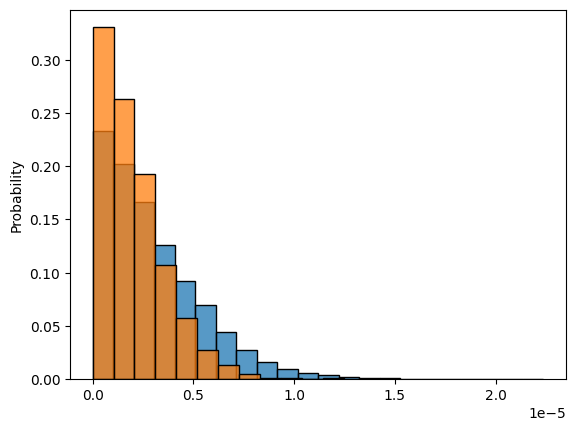

In [56]:
sns.histplot(np.abs(list(map(lambda x: x[1], filter(lambda x: x[2] != 'PERSON', token_exp_NERs)))), stat='probability', binwidth=1e-6)
sns.histplot(np.abs(list(map(lambda x: x[1], filter(lambda x: x[2] == 'PERSON', token_exp_NERs)))), stat='probability', binwidth=1e-6)

795it [14:25,  1.09s/it]
100%|██████████| 795/795 [00:00<00:00, 47949.72it/s]


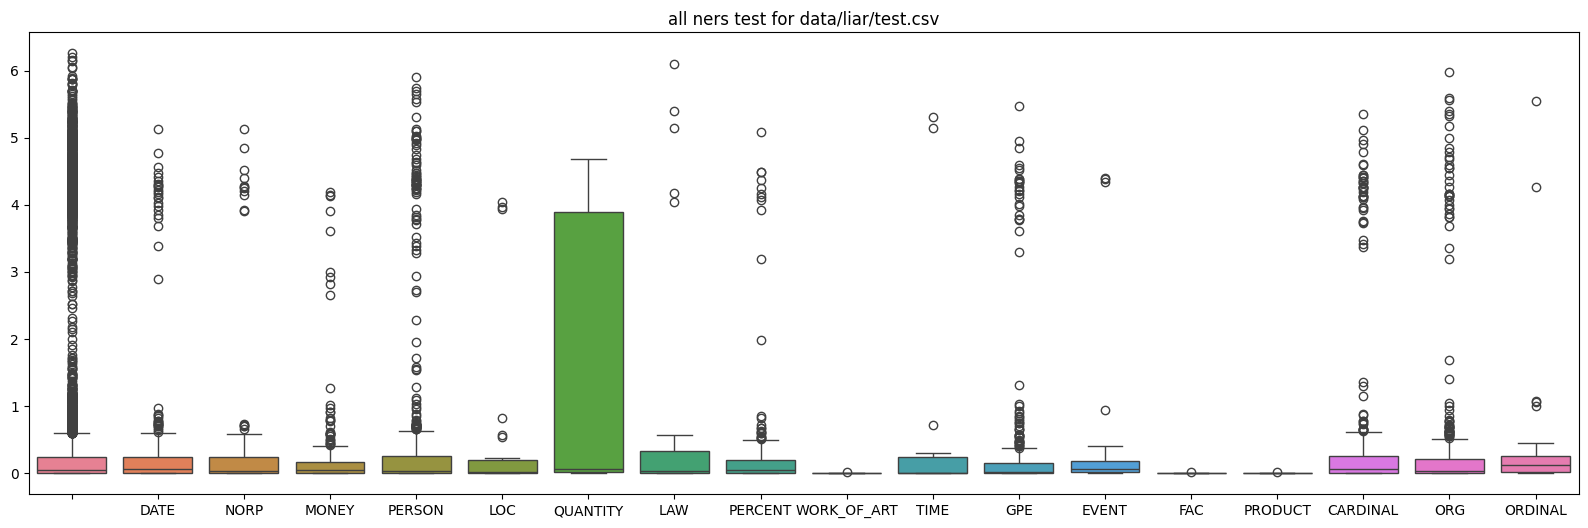

In [48]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

data_names = ["liar"]
results_for_data_all_ners= {}
for data_name in data_names:
    file = f"data/{data_name}/test.csv"
    test = pd.read_csv(file)
    token_exp_NERs = tokenize_evaluate_and_detect_NERs(pipeline,test["text"].tolist(),spacy_model =  "en_core_web_lg",)
    results_for_data_all_ners[data_name] = token_exp_NERs
    all_ner_types = set()

    for _,_,ner in token_exp_NERs:
            all_ner_types.add(ner)
            
    exps = {}
    for ner_type in all_ner_types:
        exps[ner_type] = []



    for token,exp,ner in token_exp_NERs:
        exps[ner].append(abs(exp))


    plt.figure(figsize=(20,6))
    sns.boxplot(exps)
    plt.title(f"all ners test for {file}")
    plt.show()

In [66]:
token_exp_NERs[0][2]

''

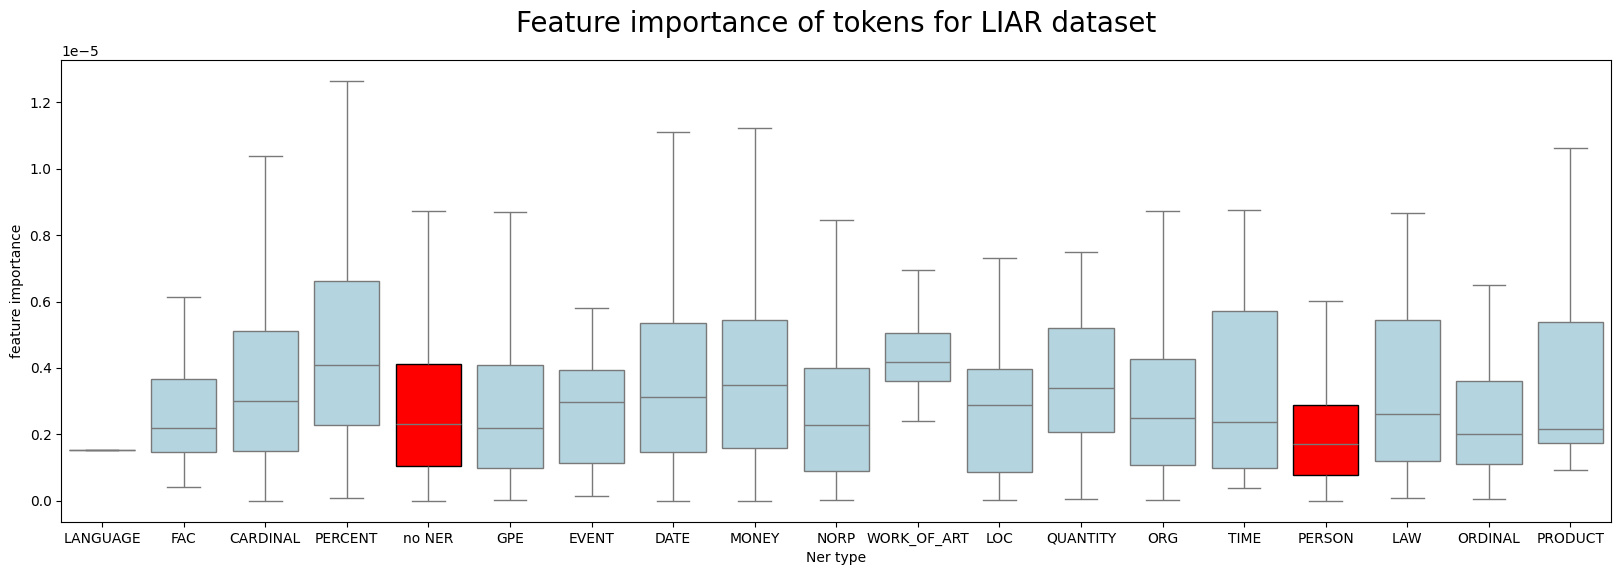

In [80]:
import matplotlib.pyplot as plt
import seaborn as sns
results_for_data_all_ners = {}
results_for_data_all_ners['liar'] = token_exp_NERs

for data_name in data_names:
    token_exp_NERs = results_for_data_all_ners[data_name]
    all_ner_types = set()

    for _, _, ner in token_exp_NERs:
        all_ner_types.add(ner if ner != '' else 'no NER')

    exps = {}
    for ner_type in all_ner_types:
        exps[ner_type] = []



    for token,exp,ner in token_exp_NERs:
        exps[ner if ner != '' else 'no NER'].append(abs(exp))

    plt.figure(figsize=(20,6))
    
    # pallete = ['g'] * 4 + ['r'] + ['g'] * 9 + ['r'] + ['g'] * 3
    
    # Assign the same color to all boxes
    box_colors = ["lightblue"] * len(exps)  # A list of the same color for all boxes
    plt.ylabel("feature importance")
    plt.xlabel("Ner type")
    ax = sns.boxplot(data=exps, palette=box_colors, showfliers=False)  # Pass the color list
    
    box = ax.patches[4]
    box.set_facecolor('red')
    box.set_edgecolor('black')
    
    box = ax.patches[15]
    box.set_facecolor('red')
    box.set_edgecolor('black')
    
    plt.title(f"Feature importance of tokens for LIAR dataset", fontsize=20, pad=20)
    plt.savefig(f"graph_output\\feature_importance_graphs\\All ner feature importance of tokens for LIAR dataset")  # Assuming you meant `data_name` instead of `file`
    plt.show()


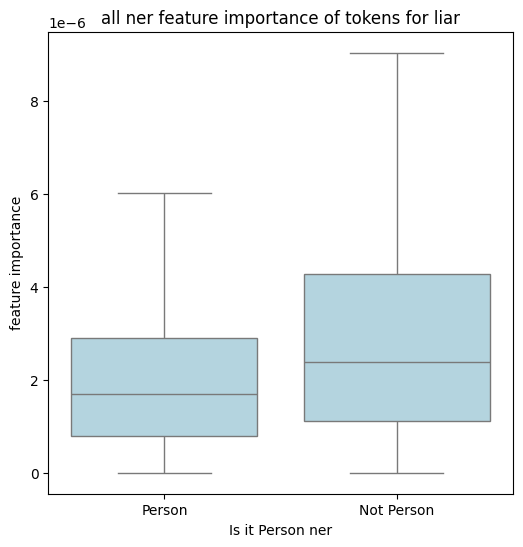

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns

for data_name in data_names:
    token_exp_NERs = results_for_data_all_ners[data_name]
    all_ner_types = set()

    for _, _, ner in token_exp_NERs:
        all_ner_types.add(ner)

    exps = {"Person":[],"Not Person":[]}


    for token, exp, ner in token_exp_NERs:
        if(ner == "PERSON"):
            exps["Person"].append(abs(exp))
        else:
            exps["Not Person"].append(abs(exp))

    plt.figure(figsize=(6, 6))
    
    # Assign the same color to all boxes
    box_colors = ["lightblue"] * len(exps)  # A list of the same color for all boxes
    plt.ylabel("feature importance")
    # plt.xlabel("Is it Person ner")
    sns.boxplot(data=exps, palette=box_colors,showfliers=False)  # Pass the color list
    plt.title(f"all ner feature importance of tokens for {data_name}")
    plt.savefig(f"graph_output\\feature_importance_graphs\\Masked feature importance of tokens for {data_name}")  # Assuming you meant `data_name` instead of `file`
    plt.show()